In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import logging
from scipy.optimize import curve_fit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from joblib import Parallel, delayed
from dask.distributed import Client
import dask
import gc
import warnings
from pmdarima.arima import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pmdarima as pm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Definiere Start- und Enddatum
start_date = '2015-01-01 00:00:00'
end_date = '2023-12-31 23:59:59'

# Funktion zur Aufbereitung der Datensätze
def prepare_dataset(df, start_date, end_date):
    # Erstelle eine Kopie des DataFrames
    df = df.copy()
    
    # Konvertiere Timestamp zu datetime und setze als Index
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('Timestamp', inplace=True)
    
    # Schneide den Zeitraum direkt nach der Indexerstellung
    df = df[start_date:end_date].copy()
    
    # Entferne Timestamp-Duplikate (behalte den ersten Eintrag)
    df = df[~df.index.duplicated(keep='first')]
    
    # Konvertiere alle numerischen Spalten zu float
    for column in df.select_dtypes(include=['object']).columns:
        try:
            df.loc[:, column] = df[column].astype(float)
        except ValueError:
            print(f"Konnte Spalte {column} nicht zu float konvertieren")
    
    return df

# Importiere und bereite die Datensätze auf
air_quality = pd.read_csv('dataset/Veenkampen_Air Quality.csv', skiprows=[1])
air_quality = prepare_dataset(air_quality, start_date, end_date)

meteorology = pd.read_csv('dataset/Veenkampen_Meteorology.csv', skiprows=[1])
meteorology = prepare_dataset(meteorology, start_date, end_date)

soil = pd.read_csv('dataset/Veenkampen_Soil.csv', skiprows=[1])
soil = prepare_dataset(soil, start_date, end_date)

# Importiere und bereite das Flux Dataset auf
fluxes = pd.read_csv('./dataset/Veenkampen_Fluxes.csv', skiprows=[1]) # Entferne die Einheitenzeile
fluxes = prepare_dataset(fluxes, start_date, end_date)

# Zeige Informationen über alle aufbereiteten Datensätze
print("\nZeitraum der Datensätze:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name}:")
    print(f"Start: {df.index.min()}")
    print(f"Ende: {df.index.max()}")
    print(f"Anzahl Datenpunkte: {len(df)}")

# Zeige Informationen über die Datensätze
print("\nDataset Infos:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name} Dataset Info:")
    print(df.info())

# Überprüfe auf fehlende Werte
print("\nFehlende Werte:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\nFehlende Werte in {name}:")
    print(df.isnull().sum())

# Überprüfe die Sampling-Raten
print("\nSampling-Intervalle:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name}:")
    print(df.index.to_series().diff().value_counts().head())








Zeitraum der Datensätze:

Air Quality:
Start: 2015-01-01 00:00:00
Ende: 2023-12-31 23:56:00
Anzahl Datenpunkte: 979527

Meteorology:
Start: 2015-01-01 00:00:00
Ende: 2023-12-31 23:59:00
Anzahl Datenpunkte: 4720489

Soil:
Start: 2015-01-01 00:00:00
Ende: 2023-12-31 23:59:00
Anzahl Datenpunkte: 4717918

Fluxes:
Start: 2015-01-01 00:00:00
Ende: 2023-12-31 23:30:00
Anzahl Datenpunkte: 140422

Dataset Infos:

Air Quality Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 979527 entries, 2015-01-01 00:00:00 to 2023-12-31 23:56:00
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   co2_mixing_ratio  130219 non-null  float64
 1   h2o_mixing_ratio  140145 non-null  float64
 2   BC                362135 non-null  float64
 3   NOx               646041 non-null  float64
 4   NO                646041 non-null  float64
 5   NO2               646041 non-null  float64
 6   O3                628638 non-nu

In [6]:
nan_counts = fluxes['co2_flux'].isna().sum()
print(f"Number of missing data: {nan_counts}")

# Number of NaN groups
missing_blocks = fluxes['co2_flux'].isna().astype(int).groupby(fluxes['co2_flux'].notna().astype(int).cumsum()).sum()
print(missing_blocks.sort_values(ascending=False).head(10))  # longest NaN sequences

Number of missing data: 10203
co2_flux
28056     350
35013     131
34984     128
23678     116
23448     108
23677      92
107643     84
23674      60
35052      53
9765       43
Name: co2_flux, dtype: int64


In [7]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

### Find out the outliers in the co2_flux data

In [3]:
# Load dataset (Ensure the correct data path is used)
data = fluxes['co2_flux'].copy()

# 1. Basic descriptive analysis of CO2 flux values
print("=== Descriptive Statistics ===")
print(data.describe())

# 2. Outlier detection using the Interquartile Range (IQR) method
# The IQR method is a robust statistical approach to identify potential outliers by assessing the data spread between the first (Q1) and third quartiles (Q3).
q1, q3 = data.quantile([0.25, 0.75])
iqr = q3 - q1
iqr_low = q1 - 1.5 * iqr  # Lower bound for moderate outliers
iqr_high = q3 + 1.5 * iqr  # Upper bound for moderate outliers

print(f"\nIQR-based thresholds: [{iqr_low:.2f}, {iqr_high:.2f}] µmol/m²/s")

# 3. Defining alternative thresholds using the 5th and 95th percentiles
# The 95% confidence interval captures the central distribution of the data, reducing the influence of extreme values.
p05, p95 = data.quantile([0.05, 0.95])
print(f"\n95% range: [{p05:.2f}, {p95:.2f}] µmol/m²/s")

# 4. Justification for threshold selection
# The IQR method is highly effective for detecting moderate outliers but may exclude valid extreme observations in dynamic natural systems.
# The 95% percentile approach is more flexible, preserving a broader range of natural variation while filtering extreme anomalies.
# For conservative outlier removal, IQR is recommended.
# For a more inclusive approach that retains natural variability, the 95% range is preferable.

# 5. Data cleaning using both methods

# Approach 1: IQR-based filtering
clean_data_iqr = data.where(
    (data >= iqr_low) & 
    (data <= iqr_high)
)

# Approach 2: 95%-based filtering
clean_data_95 = data.where(
    (data >= p05) & 
    (data <= p95)
)

# Compare data retention after filtering
print(f"\nRemaining data after filtering (IQR applied): {clean_data_iqr.count() / len(data):.1%}")
print(f"Remaining data after filtering (95% range applied): {clean_data_95.count() / len(data):.1%}")

=== Descriptive Statistics ===
count    1.302190e+05
mean     6.126728e+06
std      1.579221e+09
min     -5.072780e+02
25%     -5.093183e+00
50%      5.899440e-01
75%      3.217230e+00
max      4.559529e+11
Name: co2_flux, dtype: float64

IQR-based thresholds: [-17.56, 15.68] µmol/m²/s

95% range: [-14.81, 11.78] µmol/m²/s

Remaining data after filtering (IQR applied): 86.2%
Remaining data after filtering (95% range applied): 83.5%


### Interpolation of missing values with 95% range

Statistics of cleaned co2_flux (outliers removed):
count    117194.000000
mean         -0.718166
std           5.479319
min         -14.799859
25%          -4.354316
50%           0.591012
75%           2.861450
max          11.798248
Name: co2_flux_clean, dtype: float64


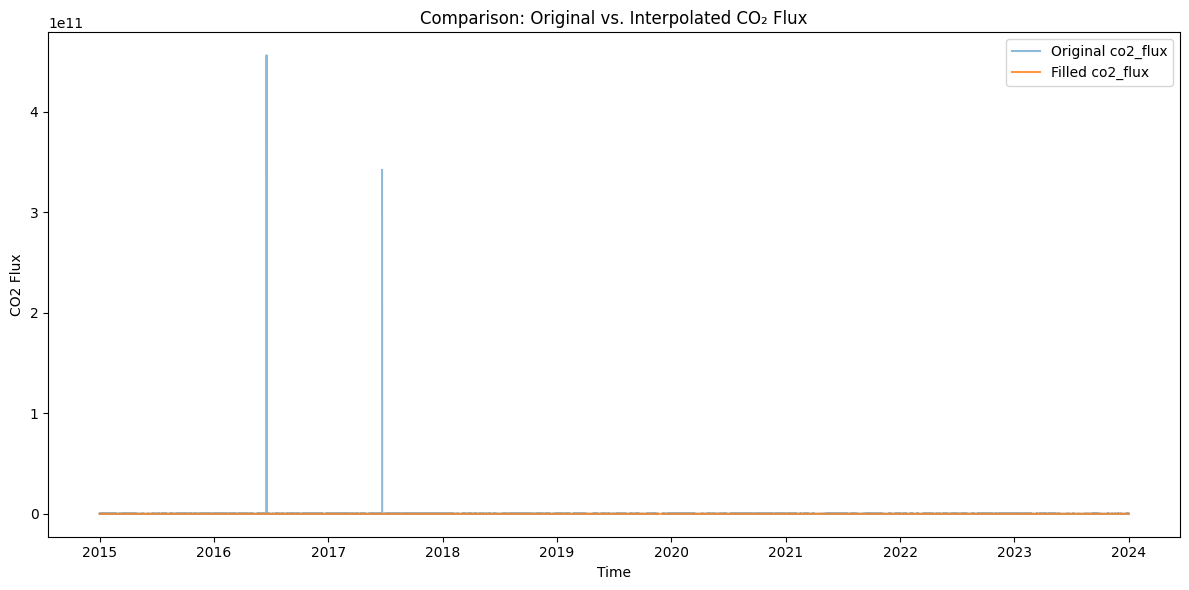


Statistics of filled co2_flux:
count    140422.000000
mean         -0.683190
std           5.534503
min         -14.799859
25%          -4.307255
50%           0.640778
75%           2.934627
max          11.798248
Name: co2_flux_filled, dtype: float64


In [4]:
# Set the random seed for reproducibility
np.random.seed(42)

# Assumption: The datasets (air_quality, meteorology, soil, fluxes) are already imported and prepared.

# ---------------------------------
# 0. Preparation: Interpolation of solar radiation data
# ---------------------------------
# The variable SW_IN_1_1_1 from the meteorology dataset is used for day/night determination.
# Interpolate missing values in SW_IN_1_1_1 using time-based interpolation.
meteorology['SW_IN_1_1_1'] = meteorology['SW_IN_1_1_1'].interpolate(method='time', limit_direction='both')

# To align solar radiation data with flux timestamps, reindex the meteorological SW_IN values 
# to match the flux dataset's time grid using the nearest method, as meteorological data is at 1-minute intervals.
flux_df = fluxes.copy()
flux_df['SW_IN'] = meteorology['SW_IN_1_1_1'].reindex(flux_df.index, method='nearest')

# ---------------------------------
# 1. Statistical analysis and outlier removal of CO₂ flux data
# ---------------------------------
# Copy the original CO₂ flux data into a new column
flux_df['co2_flux_clean'] = flux_df['co2_flux'].copy()

# Set values outside the 95% range (less than -14.8 or greater than 11.8) as outliers to NaN
flux_df.loc[(flux_df['co2_flux_clean'] < -14.8) | (flux_df['co2_flux_clean'] > 11.8), 'co2_flux_clean'] = np.nan

print("Statistics of cleaned co2_flux (outliers removed):")
print(flux_df['co2_flux_clean'].describe())

# ---------------------------------
# 2. Preparation for interpolation: Differentiating between short and long gaps
# ---------------------------------
# Determine the typical sampling interval in hours (median of time differences)
median_interval = flux_df.index.to_series().diff().median().total_seconds() / 3600.0

# Perform an initial linear time interpolation to fill all gaps
flux_df['co2_flux_lin'] = flux_df['co2_flux_clean'].interpolate(method='time', limit_direction='both')

# Identify indices of gaps longer than 1.5 hours
na_mask = flux_df['co2_flux_clean'].isna()
group_ids = (na_mask != na_mask.shift()).cumsum()
missing_groups = flux_df[na_mask].groupby(group_ids)

long_gap_indices = []
for group_id, group in missing_groups:
    # Compute the gap duration (difference between first and last timestamp plus one typical interval)
    gap_duration = (group.index[-1] - group.index[0]).total_seconds() / 3600.0 + median_interval
    if gap_duration > 1.5:
        long_gap_indices.extend(group.index)

# Reset values in the linearly interpolated series to NaN for long gaps
flux_df.loc[long_gap_indices, 'co2_flux_lin'] = np.nan

# ---------------------------------
# 3. Definition of day/night determination using solar radiation
# ---------------------------------
# Daytime is assumed when SW_IN > 20 W/m², otherwise, it is considered nighttime.
def is_day(timestamp):
    # Use the interpolated SW_IN value from the flux dataset for the given timestamp.
    # If the value is missing, default to nighttime.
    sw_value = flux_df.at[timestamp, 'SW_IN'] if pd.notnull(flux_df.at[timestamp, 'SW_IN']) else 0
    return sw_value > 20

# ---------------------------------
# 4. Gap filling using Marginal Distribution Sampling (MDS)
# ---------------------------------
# For each timestamp in long gaps, a random value is drawn from the empirical distribution of cleaned CO₂ flux data,
# based on whether it is day or night.
for ts in long_gap_indices:
    if is_day(ts):
        # Select all valid values in the daytime period (SW_IN > 5)
        pool = flux_df.loc[flux_df['SW_IN'] > 2, 'co2_flux_clean'].dropna()
    else:
        # Select all valid values in the nighttime period (SW_IN <= 5)
        pool = flux_df.loc[flux_df['SW_IN'] <= 2, 'co2_flux_clean'].dropna()
    
    if len(pool) > 0:
        flux_df.at[ts, 'co2_flux_lin'] = np.random.choice(pool.values)
    else:
        flux_df.at[ts, 'co2_flux_lin'] = np.nan

# The combined result (linear interpolation for short gaps, MDS for long gaps) 
# is stored in the column 'co2_flux_filled'.
flux_df['co2_flux_filled'] = flux_df['co2_flux_lin']

# ---------------------------------
# 5. Interpolation of external variables in the flux dataset
# ---------------------------------
# Perform a simple time interpolation for all other variables with missing values.
cols_to_exclude = ['co2_flux', 'co2_flux_clean', 'co2_flux_lin', 'co2_flux_filled', 'SW_IN']
external_cols = [col for col in flux_df.columns if col not in cols_to_exclude]

if external_cols:
    flux_df[external_cols] = flux_df[external_cols].interpolate(method='time', limit_direction='both')

# ---------------------------------
# 6. Visualization and final statistics
# ---------------------------------
plt.figure(figsize=(12, 6))
plt.plot(flux_df.index, flux_df['co2_flux'], label='Original co2_flux', alpha=0.5)
plt.plot(flux_df.index, flux_df['co2_flux_filled'], label='Filled co2_flux', alpha=0.8)
plt.xlabel("Time")
plt.ylabel("CO2 Flux")
plt.title("Comparison: Original vs. Interpolated CO₂ Flux")
plt.legend()
plt.tight_layout()
plt.show()

print("\nStatistics of filled co2_flux:")
print(flux_df['co2_flux_filled'].describe())


# Data Visualization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Import the necessary libraries

# Set a style for the plots
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({'figure.max_open_warning': 0})

# Assumption: flux_df is already available and contains the following columns:
# - 'co2_flux': Original data
# - 'co2_flux_clean': After outlier removal (values outside [-14.8, 11.8] were removed)
# - 'co2_flux_filled': After interpolation (linear interpolation for short gaps and MDS for long gaps)

# ---------------------------------
# 1. Histograms with KDE (Density Curves)
# ---------------------------------
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(flux_df['co2_flux'], bins=50, kde=True, color="steelblue")
plt.title("Histogram: Original")
plt.xlabel("CO2 Flux")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
sns.histplot(flux_df['co2_flux_clean'], bins=50, kde=True, color="seagreen")
plt.title("Histogram: After Cleaning")
plt.xlabel("CO2 Flux (Cleaned)")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
sns.histplot(flux_df['co2_flux_filled'], bins=50, kde=True, color="darkorange")
plt.title("Histogram: After Filling")
plt.xlabel("CO2 Flux (Filled)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# ---------------------------------
# 2. Boxplots to Compare Distributions
# ---------------------------------
# Create a DataFrame containing the three versions for easier boxplot visualization.
df_box = pd.DataFrame({
    "Original": flux_df['co2_flux'],
    "Cleaned": flux_df['co2_flux_clean'],
    "Filled": flux_df['co2_flux_filled']
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_box, palette=["steelblue", "seagreen", "darkorange"])
plt.title("Boxplots of CO2 Flux Data")
plt.ylabel("CO2 Flux")
plt.show()

# ---------------------------------
# 3. Density Distributions (KDE) Comparison
# ---------------------------------
plt.figure(figsize=(12, 6))
sns.kdeplot(flux_df['co2_flux'].dropna(), label="Original", shade=True, color="steelblue")
sns.kdeplot(flux_df['co2_flux_clean'].dropna(), label="Cleaned", shade=True, color="seagreen")
sns.kdeplot(flux_df['co2_flux_filled'].dropna(), label="Filled", shade=True, color="darkorange")
plt.title("Density Distributions (KDE) of CO2 Flux Data")
plt.xlabel("CO2 Flux")
plt.ylabel("Density")
plt.legend()
plt.show()

# ---------------------------------
# 4. Q-Q Plots to Check Normality Assumption
# ---------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Q-Q Plot for Original Data
stats.probplot(flux_df['co2_flux'].dropna(), dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot: Original")

# Q-Q Plot for Cleaned Data
stats.probplot(flux_df['co2_flux_clean'].dropna(), dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot: After Cleaning")

# Q-Q Plot for Filled Data
stats.probplot(flux_df['co2_flux_filled'].dropna(), dist="norm", plot=axes[2])
axes[2].set_title("Q-Q Plot: After Filling")

plt.tight_layout()
plt.show()

In [ ]:
# ---------------------------------
# 5. Rolling Statistics Analysis
# ---------------------------------
# Define the rolling window size (e.g., 48 steps for 30-minute data ~ 24 hours)
window_size = 48

# Compute rolling mean and standard deviation for original, cleaned, and filled datasets
flux_df['roll_mean_orig'] = flux_df['co2_flux'].rolling(window=window_size).mean()
flux_df['roll_std_orig'] = flux_df['co2_flux'].rolling(window=window_size).std()

flux_df['roll_mean_clean'] = flux_df['co2_flux_clean'].rolling(window=window_size).mean()
flux_df['roll_std_clean'] = flux_df['co2_flux_clean'].rolling(window=window_size).std()

flux_df['roll_mean_filled'] = flux_df['co2_flux_filled'].rolling(window=window_size).mean()
flux_df['roll_std_filled'] = flux_df['co2_flux_filled'].rolling(window=window_size).std()

plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(flux_df.index, flux_df['roll_mean_orig'], label='Rolling Mean (Original)')
plt.plot(flux_df.index, flux_df['roll_std_orig'], label='Rolling Std (Original)')
plt.title("Rolling Statistics: Original Data")
plt.legend(loc='upper right')

plt.subplot(3, 1, 2)
plt.plot(flux_df.index, flux_df['roll_mean_clean'], label='Rolling Mean (Cleaned)', color='green')
plt.plot(flux_df.index, flux_df['roll_std_clean'], label='Rolling Std (Cleaned)', color='red')
plt.title("Rolling Statistics: After Cleaning")
plt.legend(loc='upper right')

plt.subplot(3, 1, 3)
plt.plot(flux_df.index, flux_df['roll_mean_filled'], label='Rolling Mean (Filled)', color='orange')
plt.plot(flux_df.index, flux_df['roll_std_filled'], label='Rolling Std (Filled)', color='purple')
plt.title("Rolling Statistics: After Filling")
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:


# Create a figure with subplots for ACF and PACF plots across different data versions
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Original data: Analyze autocorrelation and partial autocorrelation
sm.graphics.tsa.plot_acf(flux_df['co2_flux'].dropna(), lags=48, ax=axes[0, 0], title='ACF Original')
sm.graphics.tsa.plot_pacf(flux_df['co2_flux'].dropna(), lags=48, ax=axes[0, 1], title='PACF Original')

# Cleaned data: Assess the impact of outlier removal on autocorrelation structure
sm.graphics.tsa.plot_acf(flux_df['co2_flux_clean'].dropna(), lags=48, ax=axes[1, 0], title='ACF Cleaned')
sm.graphics.tsa.plot_pacf(flux_df['co2_flux_clean'].dropna(), lags=48, ax=axes[1, 1], title='PACF Cleaned')

# Filled data: Examine the influence of interpolation on temporal dependencies
sm.graphics.tsa.plot_acf(flux_df['co2_flux_filled'].dropna(), lags=48, ax=axes[2, 0], title='ACF Filled')
sm.graphics.tsa.plot_pacf(flux_df['co2_flux_filled'].dropna(), lags=48, ax=axes[2, 1], title='PACF Filled')

# Optimize layout for better readability
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Beispielhaft mit wöchentlicher Frequenz, je nach Sampling-Rate anpassen:
freq_steps = 48 * 7  # bei 30-Minuten-Daten ~ eine Woche

# Original
decomp_orig = seasonal_decompose(flux_df['co2_flux'].dropna(), period=freq_steps, model='additive')
fig_orig = decomp_orig.plot()
fig_orig.suptitle("Seasonal Decomposition: Originaldaten", y=1.02)

# Bereinigt
decomp_clean = seasonal_decompose(flux_df['co2_flux_clean'].dropna(), period=freq_steps, model='additive')
fig_clean = decomp_clean.plot()
fig_clean.suptitle("Seasonal Decomposition: Nach Bereinigung", y=1.02)

# Auffüllt
decomp_filled = seasonal_decompose(flux_df['co2_flux_filled'].dropna(), period=freq_steps, model='additive')
fig_filled = decomp_filled.plot()
fig_filled.suptitle("Seasonal Decomposition: Nach Auffüllung", y=1.02)

plt.show()

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

# -----------------------------------------------------
# Hilfsfunktionen für ADF- und KPSS-Test
# -----------------------------------------------------

def adf_test(series, title="ADF Test"):
    """
    Führt den Augmented Dickey-Fuller-Test durch und gibt die Ergebnisse aus.
    """
    print(f"\n=== {title} ===")
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['Teststatistik', 'p-Wert', '# Lags', '# Beobachtungen']
    out = dict(zip(labels, result[0:4]))
    
    for key, val in out.items():
        print(f"  {key}: {val}")
    
    # Kritische Werte
    for k, v in result[4].items():
        print(f"  Kritischer Wert {k}: {v:.3f}")
    
    if out['p-Wert'] < 0.05:
        print("  => Stationär (Nullhypothese abgelehnt, p<0.05)")
    else:
        print("  => Nicht stationär (Nullhypothese nicht abgelehnt, p>=0.05)")

def kpss_test(series, title="KPSS Test", regression='c'):
    """
    Führt den KPSS-Test durch und gibt die Ergebnisse aus.
    regression='c' testet auf stationäre Zeitreihe mit Konstanten;
    regression='ct' testet auf stationäre Zeitreihe mit Trend.
    """
    print(f"\n=== {title} ===")
    result = kpss(series.dropna(), regression=regression, nlags="auto")
    labels = ['Teststatistik', 'p-Wert', '# Lags']
    out = dict(zip(labels, result[0:3]))
    
    for key, val in out.items():
        print(f"  {key}: {val}")
    
    # Kritische Werte
    for k, v in result[3].items():
        print(f"  Kritischer Wert {k}: {v}")
    
    # Interpretation
    if out['p-Wert'] < 0.05:
        print("  => Nicht stationär (Nullhypothese abgelehnt, p<0.05)")
    else:
        print("  => Stationär (Nullhypothese nicht abgelehnt, p>=0.05)")

# -----------------------------------------------------
# Hauptcode: Verschiedene Zeitreihen-Perioden testen
# -----------------------------------------------------

# Beispiel: Angenommen, wir haben 30-Minuten-Daten in flux_df['co2_flux_filled']
# (bereits bereinigt und aufgefüllt). Falls du Originaldaten testen willst,
# kannst du die entsprechende Spalte auswählen.
time_series = flux_df['co2_flux_filled'].dropna()

# Definiere verschiedene Perioden (in "Anzahl Datenpunkte pro Zyklus")
periods = {
    "Täglich": 48,          # 30-minütige Daten => 48 pro Tag
    "Wöchentlich": 336,     # 48 * 7
    "Monatlich": 1440,      # 48 * 30 (vereinfacht)
    "Jährlich": 17520       # 48 * 365 (vereinfacht)
}

for period_name, period_val in periods.items():
    print(f"\n\n{'='*50}")
    print(f"Analyse für {period_name} (Periode={period_val})")
    print(f"{'='*50}\n")
    
    # 1) Saisonalitätszerlegung
    # Hinweis: Falls nicht genug Daten für so eine lange Periode vorhanden sind,
    # kann seasonal_decompose fehlschlagen oder Warnungen werfen.
    try:
        decomposition = seasonal_decompose(time_series, period=period_val, model='additive', extrapolate_trend='freq')
        
        # Plot
        fig = decomposition.plot()
        fig.suptitle(f"Seasonal Decomposition ({period_name})", y=1.02)
        fig.set_size_inches(14,8)
        plt.tight_layout()
        plt.show()
        
        # Optional: Extrahiere Residuen und Trend
        resid = decomposition.resid
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        
        # 2) Stationaritätstests auf Original-Zeitreihe (bzw. 'time_series')
        adf_test(time_series, title=f"ADF: {period_name} - Originalserie")
        kpss_test(time_series, title=f"KPSS: {period_name} - Originalserie", regression='c')
        
        # 3) Stationaritätstests auf Residuen (falls vorhanden)
        #    => Residuen sollten bei gut modellierter Saisonalität + Trend stationär sein
        adf_test(resid, title=f"ADF: {period_name} - Residuen")
        kpss_test(resid, title=f"KPSS: {period_name} - Residuen", regression='c')
        
    except ValueError as e:
        print(f"Fehler oder zu wenige Daten für Periode {period_val}: {e}")
    except Exception as e:
        print(f"Allgemeiner Fehler bei der Zerlegung für Periode {period_val}: {e}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_seasonality(data):
    """
    Analyzes and visualizes the seasonality of CO2 flux across different time scales.
    
    Args:
        data: Pandas Series with a DateTime index (e.g., flux_df['co2_flux_filled']).
    
    Returns:
        A tuple containing:
        - daily: DataFrame with mean and standard deviation of diurnal variations.
        - yearly_grouped: DataFrame with mean and standard deviation of annual variations.
        - monthly_means: DataFrame with mean CO2 flux for each month over multiple years.
    """
    
    # Convert input Series to a DataFrame for easier manipulation
    df = pd.DataFrame({'co2_flux': data})
    
    # Initialize figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('CO2 Flux Seasonality Across Different Time Scales', fontsize=16, y=1.02)
    
    # 1. Diurnal cycle analysis (mean and standard deviation)
    daily = df.groupby(df.index.hour)['co2_flux'].agg(['mean', 'std'])
    axes[0, 0].plot(daily.index, daily['mean'], 'b-', label='Mean')
    axes[0, 0].fill_between(daily.index, 
                            daily['mean'] - daily['std'],
                            daily['mean'] + daily['std'],
                            alpha=0.2, color='b')
    axes[0, 0].set_title('Mean Diurnal Cycle')
    axes[0, 0].set_xlabel('Hour of the Day')
    axes[0, 0].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[0, 0].grid(True)
    
    # 2. Annual cycle analysis (daily means)
    yearly = df.resample('D').mean()
    yearly_grouped = yearly.groupby(yearly.index.dayofyear)['co2_flux'].agg(['mean', 'std'])
    axes[0, 1].plot(yearly_grouped.index, yearly_grouped['mean'], 'g-', label='Mean')
    axes[0, 1].fill_between(yearly_grouped.index,
                            yearly_grouped['mean'] - yearly_grouped['std'],
                            yearly_grouped['mean'] + yearly_grouped['std'],
                            alpha=0.2, color='g')
    axes[0, 1].set_title('Mean Annual Cycle (Daily Averages)')
    axes[0, 1].set_xlabel('Day of the Year')
    axes[0, 1].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[0, 1].grid(True)
    
    # 3. Monthly boxplots for variability analysis
    monthly = df.groupby(df.index.month)['co2_flux']
    axes[1, 0].boxplot([monthly.get_group(i) for i in range(1, 13)],
                       labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axes[1, 0].set_title('Monthly Distribution of CO2 Flux')
    axes[1, 0].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[1, 0].grid(True)
    
    # 4. Long-term monthly mean trends
    monthly_means = df.resample('M').mean()
    axes[1, 1].plot(monthly_means.index, monthly_means['co2_flux'], 'r-')
    axes[1, 1].set_title('Monthly Mean CO2 Flux Over Time')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[1, 1].grid(True)
    
    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()
    
    # Display statistical insights related to seasonality
    print("\nStatistical Summary of Seasonality:")
    
    print("\n1. Diurnal Cycle:")
    print(f"Maximum mean flux occurs at {daily['mean'].idxmax()} hours: {daily['mean'].max():.2f}")
    print(f"Minimum mean flux occurs at {daily['mean'].idxmin()} hours: {daily['mean'].min():.2f}")
    
    print("\n2. Annual Cycle:")
    print(f"Maximum annual mean flux on day {yearly_grouped['mean'].idxmax()}: {yearly_grouped['mean'].max():.2f}")
    print(f"Minimum annual mean flux on day {yearly_grouped['mean'].idxmin()}: {yearly_grouped['mean'].min():.2f}")
    
    # Compute seasonal amplitudes for daily and yearly cycles
    daily_range = daily['mean'].max() - daily['mean'].min()
    yearly_range = yearly_grouped['mean'].max() - yearly_grouped['mean'].min()
    
    print("\n3. Seasonal Amplitudes:")
    print(f"Diurnal Amplitude: {daily_range:.2f}")
    print(f"Annual Amplitude: {yearly_range:.2f}")
    
    # Generate heatmap of CO2 flux variations across months and hours
    pivot_data = df.pivot_table(
        values='co2_flux',
        index=df.index.month,
        columns=df.index.hour,
        aggfunc='mean'
    )
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_data, 
                cmap='RdYlBu_r',
                center=0,
                yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.title('CO2 Flux: Mean Values by Month and Hour')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Month')
    plt.show()
    
    return daily, yearly_grouped, monthly_means

# Execute the seasonality analysis
daily_patterns, yearly_patterns, monthly_trends = analyze_seasonality(flux_df['co2_flux_filled'])

# Optional: Save the results for further analysis
# daily_patterns.to_csv('daily_patterns.csv')
# yearly_patterns.to_csv('yearly_patterns.csv')
# monthly_trends.to_csv('monthly_trends.csv')

# Data Manipulation

### Try to optimize parameters via grid search but failed

In [ ]:
import numpy as np
import pandas as pd
import warnings
import gc
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed, Memory

def evaluate_sarimax_cached(y, X, params, train_idx, test_idx, seasonal_period):
    """
    Evaluiert das SARIMAX-Modell für gegebene Parameter und Indices.
    y, X: numpy-Arrays der Zeitreihe bzw. exogenen Variablen.
    train_idx, test_idx: Listen mit Indices.
    """
    y_train = y[train_idx]
    y_test = y[test_idx]
    X_train = X[train_idx] if X is not None else None
    X_test = X[test_idx] if X is not None else None
    p, d, q, P, D, Q, s = params
    try:
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False,
            initialization='approximate_diffuse'
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            results = model.fit(disp=False, maxiter=200, method='powell')
        forecast = results.get_forecast(steps=len(y_test), exog=X_test)
        predictions = forecast.predicted_mean
        return {
            'params': params,
            'metrics': {
                'mae': mean_absolute_error(y_test, predictions),
                'mse': mean_squared_error(y_test, predictions),
                'rmse': np.sqrt(mean_squared_error(y_test, predictions)),
                'aic': results.aic
            },
            'status': 'success'
        }
    except Exception as e:
        return {
            'params': params,
            'metrics': {'mae': np.inf, 'mse': np.inf, 'rmse': np.inf, 'aic': np.inf},
            'status': str(e)
        }
    finally:
        gc.collect()

def custom_time_series_split(y, n_splits, test_size):
    n_samples = len(y)
    indices = np.arange(n_samples)
    for i in range(n_splits):
        test_start = n_samples - test_size * (n_splits - i)
        if test_start < 0:
            raise ValueError(f"Nicht genügend Daten für {n_splits} Splits mit test_size {test_size}")
        train_idx = indices[:test_start]
        test_idx = indices[test_start:test_start + test_size]
        yield train_idx.tolist(), test_idx.tolist()

def worker_wrapper(y, X, params, train_idx, test_idx, seasonal_period):
    res = evaluate_sarimax_cached(y, X, params, train_idx, test_idx, seasonal_period)
    print(f"Worker finished for parameters: {params} with status: {res['status']}", flush=True)
    return res



class SARIMAXGridSearch:
    def __init__(self, y, X=None, seasonal_period=24):
        self.y = np.asarray(y, dtype=np.float64)
        self.X = np.asarray(X, dtype=np.float64) if X is not None else None
        self.seasonal_period = seasonal_period
        self.cache_dir = Path("./cache")
        self.cache_dir.mkdir(exist_ok=True)
        self.memory = Memory(location=str(self.cache_dir), verbose=0)
    
    def grid_search(self, param_grid, cv_splits=3, n_jobs=4):
        test_size = self.seasonal_period * 7
        cv = list(custom_time_series_split(self.y, cv_splits, test_size))
        
        param_combinations = [
            (p, d, q, P, D, Q, self.seasonal_period)
            for p in param_grid['p']
            for d in param_grid['d']
            for q in param_grid['q']
            for P in param_grid['P']
            for D in param_grid['D']
            for Q in param_grid['Q']
        ]
        
        results = []
        cached_worker = self.memory.cache(worker_wrapper)

        for fold_idx, (train_idx, test_idx) in enumerate(cv, 1):
            print(f"\nProcessing fold {fold_idx}/{cv_splits}")
            
            # Cache-Check für diese Faltung
            cached_for_fold = []
            for params in param_combinations:
                if cached_worker.check_call_in_cache(
                    self.y, self.X, params, train_idx, test_idx, self.seasonal_period
                ):
                    cached_for_fold.append(params)
            
            if cached_for_fold:
                print(f"🔄 Gefundene gecachte Ergebnisse ({len(cached_for_fold)}):")
                for p in cached_for_fold:
                    print(f"  SARIMAX({p[0]},{p[1]},{p[2]})x({p[3]},{p[4]},{p[5]},{p[6]})")
                print(f"Neue Berechnungen: {len(param_combinations)-len(cached_for_fold)}")
            else:
                print("ℹ️ Keine gecachten Ergebnisse gefunden, starte alle Berechnungen neu")

            fold_results = Parallel(n_jobs=n_jobs, verbose=10)(
                delayed(cached_worker)(
                    self.y,
                    self.X,
                    params,
                    train_idx,
                    test_idx,
                    self.seasonal_period
                ) for params in param_combinations
            )
            
            successful = [r for r in fold_results if r['status'] == 'success']
            results.extend(successful)
            print(f"✅ Fold {fold_idx} abgeschlossen - Erfolgreich: {len(successful)}")

        if not results:
            raise ValueError("Keine erfolgreichen Modellanpassungen")

        results_df = pd.DataFrame([{
            'p': r['params'][0],
            'd': r['params'][1],
            'q': r['params'][2],
            'P': r['params'][3],
            'D': r['params'][4],
            'Q': r['params'][5],
            'mae': r['metrics']['mae'],
            'mse': r['metrics']['mse'],
            'rmse': r['metrics']['rmse'],
            'aic': r['metrics']['aic'],
            'status': r['status']
        } for r in results])
        
        best_params = results_df.loc[results_df.groupby(['p','d','q','P','D','Q'])['aic'].idxmin()]
        return {
            'best_params': best_params.iloc[0][['p','d','q','P','D','Q']].to_dict(),
            'results': results_df,
            'best_model_stats': best_params.iloc[0]
        }

# --- Nutzung im Notebook ---

# Beispiel: flux_df ist Dein DataFrame mit einem DatetimeIndex und den Spalten 'co2_flux_filled' und 'SW_IN'
flux_df_hourly = flux_df.resample('h').mean().dropna()

y = flux_df_hourly['co2_flux_filled'].values.astype(np.float64)
X = flux_df_hourly[['SW_IN']].values.astype(np.float64)

param_grid = {
    'p': [0, 1, 2],
    'd': [0, 1],
    'q': [0, 1, 2],
    'P': [0, 1],
    'D': [0, 1],
    'Q': [0, 1]
}

searcher = SARIMAXGridSearch(y, X, seasonal_period=24)
results = searcher.grid_search(param_grid, cv_splits=3, n_jobs=-1)

print("\nBeste Parameter gefunden:")
print(results['best_params'])


Processing fold 1/3
🔄 Gefundene gecachte Ergebnisse (77):
  SARIMAX(0,0,0)x(0,0,0,24)
  SARIMAX(0,0,0)x(0,0,1,24)
  SARIMAX(0,0,0)x(0,1,0,24)
  SARIMAX(0,0,0)x(0,1,1,24)
  SARIMAX(0,0,0)x(1,0,0,24)
  SARIMAX(0,0,0)x(1,0,1,24)
  SARIMAX(0,0,0)x(1,1,0,24)
  SARIMAX(0,0,0)x(1,1,1,24)
  SARIMAX(0,0,1)x(0,0,0,24)
  SARIMAX(0,0,1)x(0,0,1,24)
  SARIMAX(0,0,1)x(0,1,0,24)
  SARIMAX(0,0,1)x(0,1,1,24)
  SARIMAX(0,0,1)x(1,0,0,24)
  SARIMAX(0,0,1)x(1,0,1,24)
  SARIMAX(0,0,1)x(1,1,0,24)
  SARIMAX(0,0,1)x(1,1,1,24)
  SARIMAX(0,0,2)x(0,0,0,24)
  SARIMAX(0,0,2)x(0,0,1,24)
  SARIMAX(0,0,2)x(0,1,0,24)
  SARIMAX(0,0,2)x(0,1,1,24)
  SARIMAX(0,0,2)x(1,0,0,24)
  SARIMAX(0,0,2)x(1,0,1,24)
  SARIMAX(0,0,2)x(1,1,0,24)
  SARIMAX(0,1,0)x(0,0,0,24)
  SARIMAX(0,1,0)x(0,0,1,24)
  SARIMAX(0,1,0)x(0,1,0,24)
  SARIMAX(0,1,0)x(0,1,1,24)
  SARIMAX(0,1,0)x(1,0,0,24)
  SARIMAX(0,1,0)x(1,0,1,24)
  SARIMAX(0,1,0)x(1,1,0,24)
  SARIMAX(0,1,0)x(1,1,1,24)
  SARIMAX(0,1,1)x(0,0,0,24)
  SARIMAX(0,1,1)x(0,0,1,24)
  SARIMAX(0,1,1)x

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19091142987252557s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from joblib import Parallel, delayed, Memory
from pathlib import Path
import gc
import warnings

# 1. Datenvorbereitung mit Saisonalitäts-Features
def prepare_data(df):
    df_hourly = df.resample('h').mean().dropna()

    # Fourier-Features für jährliche Saisonalität
    df_hourly['fourier_sin'] = np.sin(2 * np.pi * df_hourly.index.dayofyear / 365)
    df_hourly['fourier_cos'] = np.cos(2 * np.pi * df_hourly.index.dayofyear / 365)

    # Trend-Feature
    df_hourly['linear_trend'] = np.arange(len(df_hourly)) / len(df_hourly)

    return df_hourly

# 2. Stationaritäts-Checks
def check_stationarity(series):
    print("\n--- Stationaritätsanalyse ---")

    # ADF-Test
    adf = adfuller(series.dropna())
    print(f"ADF p-value: {adf[1]:.4f}")

    # KPSS-Test
    kpss_test = kpss(series.dropna(), regression='ct')
    print(f"KPSS p-value: {kpss_test[1]:.4f}")

    # Visual Check
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    series.plot(ax=ax[0], title="Original Series")
    series.diff(24).dropna().plot(ax=ax[1], title="24h Differenced Series")
    plt.tight_layout()
    plt.show()

# Top-level Funktion für das Modell-Fitting, um Pickling-Probleme zu vermeiden
def fit_model_func(y, X, seasonal_period, params):
    p, d, q, P, D, Q = params
    # Wird nur ausgeführt, wenn kein Cacheeintrag existiert
    print(f"Kein Cache gefunden, berechne Modell für Parameterkombination: {params}")
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = SARIMAX(
                y,
                exog=X,
                order=(p, d, q),
                seasonal_order=(P, D, Q, seasonal_period),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(method='lbfgs', maxiter=100, disp=False, low_memory=True)

            if np.any(np.abs(result.arparams) > 1) or np.any(np.abs(result.maparams) > 1):
                raise ValueError("Nicht-invertible Parameter")

            return {
                'params': params,
                'aic': result.aic,
                'bic': result.bic,
                'converged': True
            }
    except Exception as e:
        return {
            'params': params,
            'error': str(e),
            'converged': False
        }
    finally:
        gc.collect()

# 3. Optimierte Grid Search Klasse
class AdvancedSARIMAXSearch:
    def __init__(self, y, X=None, seasonal_period=24):
        """
        Initialisiert die erweiterte Grid-Suche für SARIMAX-Modelle.
        """
        self.y = y.astype(np.float32)
        self.X = X.astype(np.float32) if X is not None else None
        self.seasonal_period = seasonal_period
        self.cache_dir = Path("./sarimax_cache")
        self.cache_dir.mkdir(exist_ok=True)
        self.memory = Memory(location=str(self.cache_dir), verbose=0)

    def search(self, param_grid, n_jobs=-1):
        """
        Führt eine Grid-Suche mit den angegebenen Parametern durch.
        """
        self._validate_grid(param_grid)
        combinations = [
            (p, d, q, P, D, Q)
            for p in param_grid['p']
            for d in param_grid['d']
            for q in param_grid['q']
            for P in param_grid['P']
            for D in param_grid['D']
            for Q in param_grid['Q']
        ]
        
        # Cached-Funktion erstellen
        cached_fit = self.memory.cache(fit_model_func)

        # Wrapper-Funktion mit zusätzlichen Print-Ausgaben
        def cached_fit_with_print(params):
            print(f"\n>>> Verarbeite Parameterkombination: {params} ...", flush=True)
            result = cached_fit(self.y, self.X, self.seasonal_period, params)
            print(f"<<< Parameterkombination {params} abgeschlossen.", flush=True)
            return result

        results = []
        chunk_size = 10
        num_chunks = (len(combinations) + chunk_size - 1) // chunk_size
        for i in range(num_chunks):
            chunk = combinations[i * chunk_size : (i + 1) * chunk_size]
            print(f"\n=== Verarbeite Chunk {i + 1} von {num_chunks} (Kombinationen: {chunk}) ===")
            chunk_results = Parallel(n_jobs=n_jobs, verbose=11, backend='loky')(
                delayed(cached_fit_with_print)(params) for params in chunk
            )
            results.extend(chunk_results)
            print(f"=== Chunk {i + 1} abgeschlossen. ===")

        valid_results = [r for r in results if r.get('converged', False)]
        if not valid_results:
            raise ValueError("Keine konvergierten Modelle", flush=True)

        df = pd.DataFrame(valid_results).sort_values('aic')
        self._plot_results(df)
        return df

    def _validate_grid(self, grid):
        required = ['p', 'd', 'q', 'P', 'D', 'Q']
        if any(k not in grid for k in required):
            missing = [k for k in required if k not in grid]
            raise ValueError(f"Fehlende Parameter: {missing}")

    def _plot_results(self, results_df):
        plt.figure(figsize=(10, 6))
        plt.bar(results_df['params'].astype(str), results_df['aic'])
        plt.title("AIC-Werte der Modellkombinationen")
        plt.xlabel("Parameterkombination")
        plt.ylabel("AIC")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

# 4. Hauptworkflow
if __name__ == "__main__":
    flux_filtered = flux_df.loc['2019-01-01':'2019-05-31']
    # Annahme: flux_df ist bereits im Workspace vorhanden
    flux_df_hourly = prepare_data(flux_filtered.copy())  # flux_df kopieren, um Originaldaten zu schützen

    # Stationaritätsprüfung
    check_stationarity(flux_df_hourly['co2_flux_filled'])

    # Datenkonvertierung
    y = flux_df_hourly['co2_flux_filled'].values.astype(np.float32)
    X = flux_df_hourly[['SW_IN', 'fourier_sin', 'fourier_cos', 'linear_trend']].values.astype(np.float32)

    # Parameter Grid
    param_grid = {
        'p': [1, 2],
        'd': [0, 1],
        'q': [1, 2],
        'P': [1],
        'D': [1],
        'Q': [1]
    }

    # Grid Search durchführen
    searcher = AdvancedSARIMAXSearch(y, X, seasonal_period=24)
    results = searcher.search(param_grid, n_jobs=-1)

    # Bestes Modell auswählen
    best_params = results.iloc[0]['params']
    print(f"\n🏆 Beste Parameterkombination: {best_params}")

    # Finales Modell trainieren
    final_model = SARIMAX(
        y,
        exog=X,
        order=best_params[:3],
        seasonal_order=best_params[3:] + (24,)
    ).fit(disp=False)

    # Diagnostik-Plots
    final_model.plot_diagnostics(figsize=(15, 12))
    plt.show()

    # Zusammenfassung
    print(final_model.summary())

### SARIMAX optimize parameters via grid search


 Determining optimal differencing order...


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: F

Recommended differencing orders: d=0, D=0


<Figure size 1500x600 with 0 Axes>

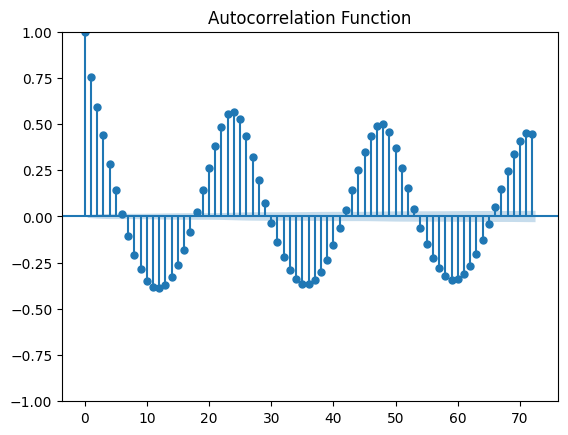

<Figure size 1500x600 with 0 Axes>

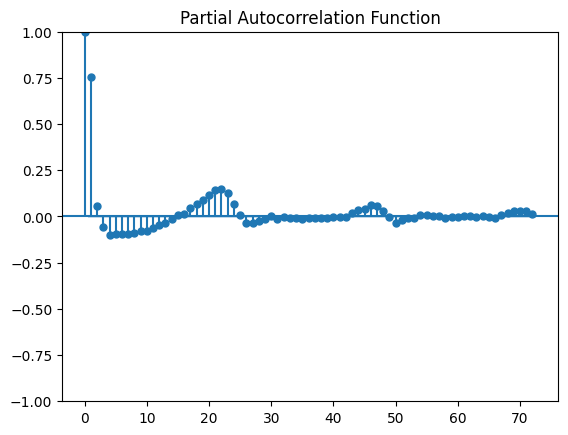

Dask cluster initialized: <Client: 'tcp://127.0.0.1:55945' processes=4 threads=8, memory=14.90 GiB>

Starting parallel model search...

Best Model (AIC 318730.3):
SARIMAX(1, 0, 1)x(1, 0, 1, 24)


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


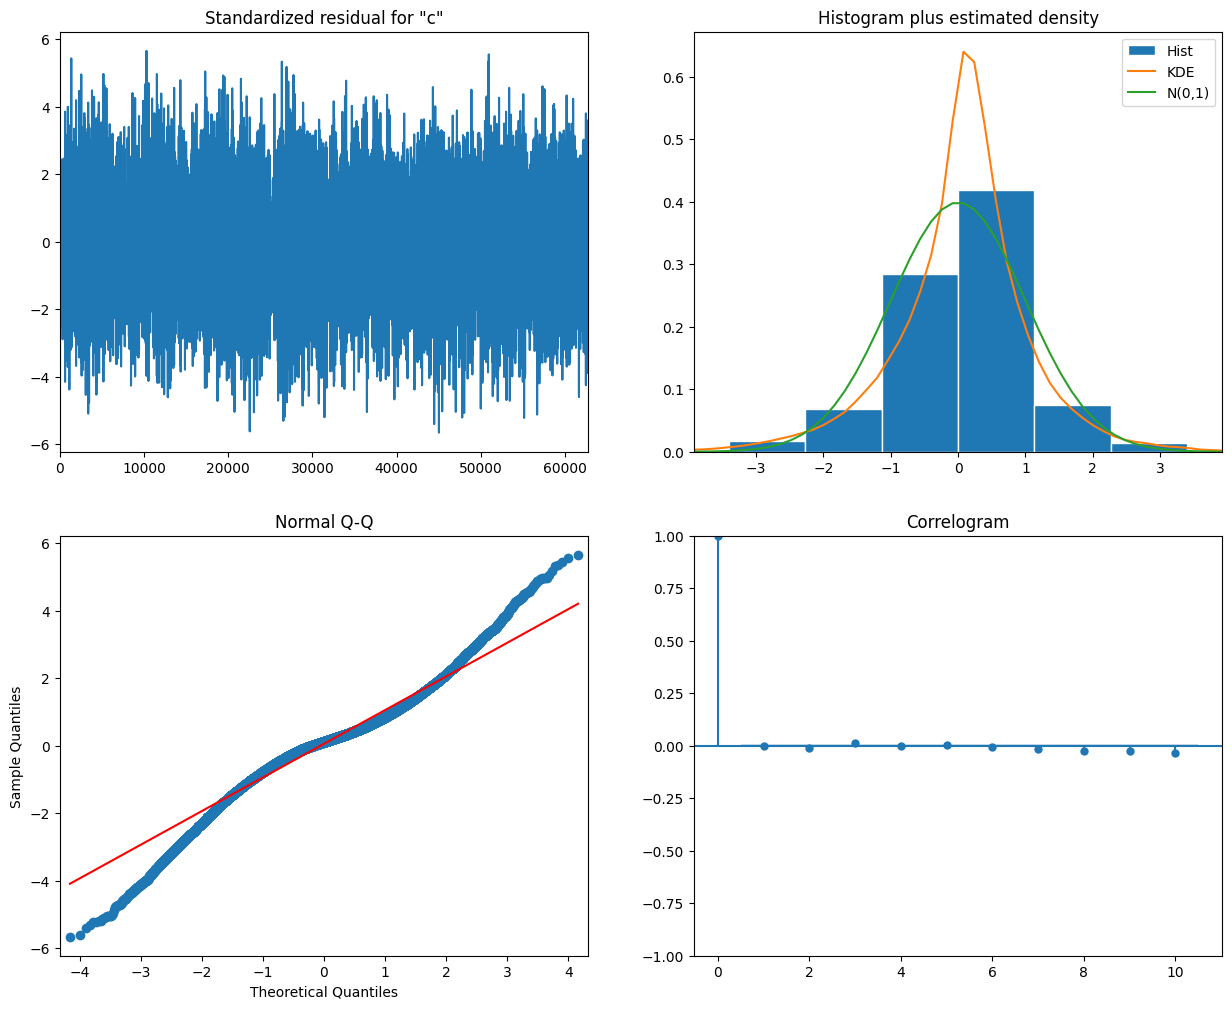

                                     SARIMAX Results                                      
Dep. Variable:                    co2_flux_filled   No. Observations:                62749
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -159204.596
Date:                            Mon, 03 Mar 2025   AIC                         318421.191
Time:                                    15:08:18   BIC                         318475.472
Sample:                                         0   HQIC                        318438.017
                                          - 62749                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SW_IN         -0.0118      0.000   -114.143      0.000      -0.012      -0.012
ar.L1          0.6796      0.005   

In [18]:
# 1. Memory-Optimized Data Preparation
def prepare_data(df, start_date, end_date):
    """Cleans and transforms the input data."""
    df = df.loc[start_date:end_date].resample('h').mean()
    
    # Memory optimizations
    numeric_cols = df.select_dtypes(np.float64).columns
    df[numeric_cols] = df[numeric_cols].astype(np.float32)
    
    # Reduce to required columns
    df = df[['co2_flux_filled', 'SW_IN']].copy()
    return df.dropna()

# 2. Automated Differencing Determination
def determine_differencing(y):
    """Determines the optimal order of differencing using statistical tests."""
    print("\n Determining optimal differencing order...")
    
    # Non-seasonal differencing
    d = ndiffs(y, test='adf', max_d=2)
    
    # Seasonal differencing (24h)
    D = nsdiffs(y, m=24, test='ocsb', max_D=2)
    
    print(f"Recommended differencing orders: d={d}, D={D}")
    return d, D

# 3. Seasonality Analysis
def analyze_seasonality(y, lags=72):
    """Performs ACF/PACF analysis."""
    plt.figure(figsize=(15, 6))
    plot_acf(y, lags=lags, alpha=0.05, title="Autocorrelation Function")
    plt.show()
    
    plt.figure(figsize=(15, 6))
    plot_pacf(y, lags=lags, alpha=0.05, title="Partial Autocorrelation Function")
    plt.show()

# 4. Parallelization Setup
def initialize_cluster():
    """Starts a Dask cluster for parallel computations."""
    client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB')
    print("Dask cluster initialized:", client)
    return client

# 5. SARIMAX Model Fitting with Robust Error Handling
@dask.delayed
def fit_sarimax(y, X, order, seasonal_order):
    """Fits a SARIMAX model with robust error handling."""
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            model = SARIMAX(
                endog=y.astype(np.float32),
                exog=X.astype(np.float32) if X is not None else None,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=True,
                enforce_invertibility=True,
                initialization='approximate_diffuse'
            )
            
            result = model.fit(
                method='powell',
                maxiter=50,
                disp=False,
                low_memory=True
            )
            
            return {
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': result.aic,
                'bic': result.bic,
                'mae': mean_absolute_error(y, result.fittedvalues)
            }
            
    except Exception as e:
        print(f"Error with {order}{seasonal_order}: {str(e)[:80]}")
        return None
    finally:
        gc.collect()

# 6. Main Workflow with Extended Validations

# Load data
df = prepare_data(flux_df, '2015-01-01', '2023-12-31')

# Split data into train and test sets
train_end = '2022-12-31'
train_data = df.loc[:train_end]
test_data = df.loc[train_end:]

y_train = train_data['co2_flux_filled']
X_train = train_data[['SW_IN']]
y_test = test_data['co2_flux_filled']
X_test = test_data[['SW_IN']]

# Determine differencing orders
d, D = determine_differencing(y_train)

# Seasonality analysis
analyze_seasonality(y_train)

# Parameter grid based on ACF/PACF
param_grid = {
    'p': [0, 1, 2],
    'q': [0, 1, 2],
    'P': [0, 1],
    'Q': [0, 1]
}

# Initialize cluster
client = initialize_cluster()

# Parallelized grid search
print("\nStarting parallel model search...")
tasks = []
for p in param_grid['p']:
    for q in param_grid['q']:
        for P in param_grid['P']:
            for Q in param_grid['Q']:
                tasks.append(
                    fit_sarimax(
                        y_train.values,
                        X_train.loc[y_train.index].values if X_train is not None else None,
                        (p, d, q),
                        (P, D, Q, 24)
                    )
                )

# Process results
results = dask.compute(*tasks)
valid_results = [r for r in results if r is not None]

if not valid_results:
    raise ValueError("No models successfully fitted")

results_df = pd.DataFrame(valid_results).sort_values('aic')

# Output best model
best_model = results_df.iloc[0]
print(f"\nBest Model (AIC {best_model.aic:.1f}):")
print(f"SARIMAX{best_model.order}x{best_model.seasonal_order}")

# Train final model
final_model = SARIMAX(
    y_train,
    exog=X_train.loc[y_train.index] if X_train is not None else None,
    order=best_model.order,
    seasonal_order=best_model.seasonal_order
).fit(disp=True)

# Diagnostics
final_model.plot_diagnostics(figsize=(15, 12))
plt.show()
print(final_model.summary())

# Close cluster
client.close()



/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


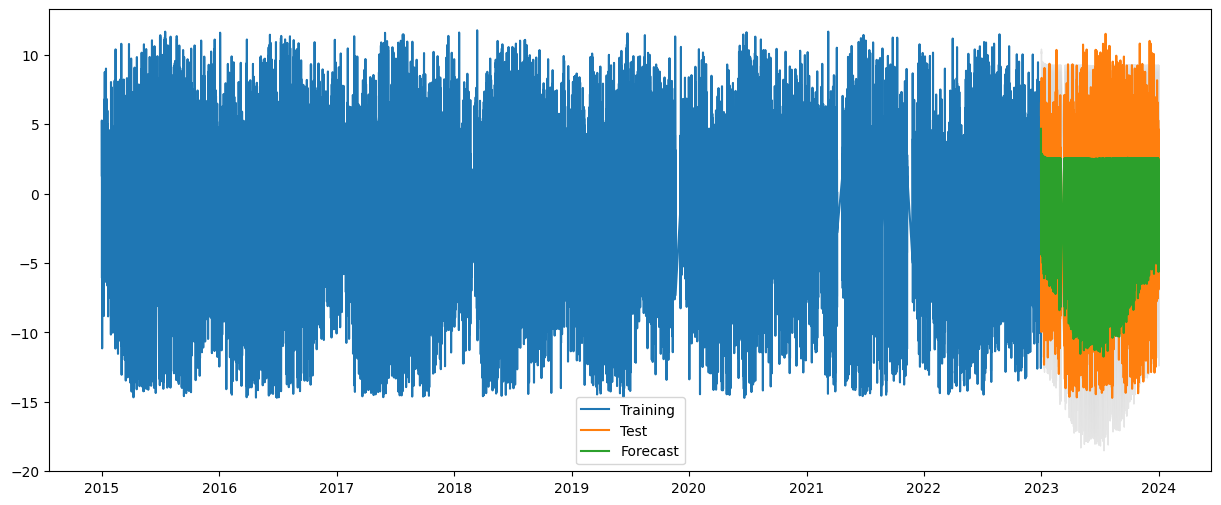

MAE: 2.722
RMSE: 3.613


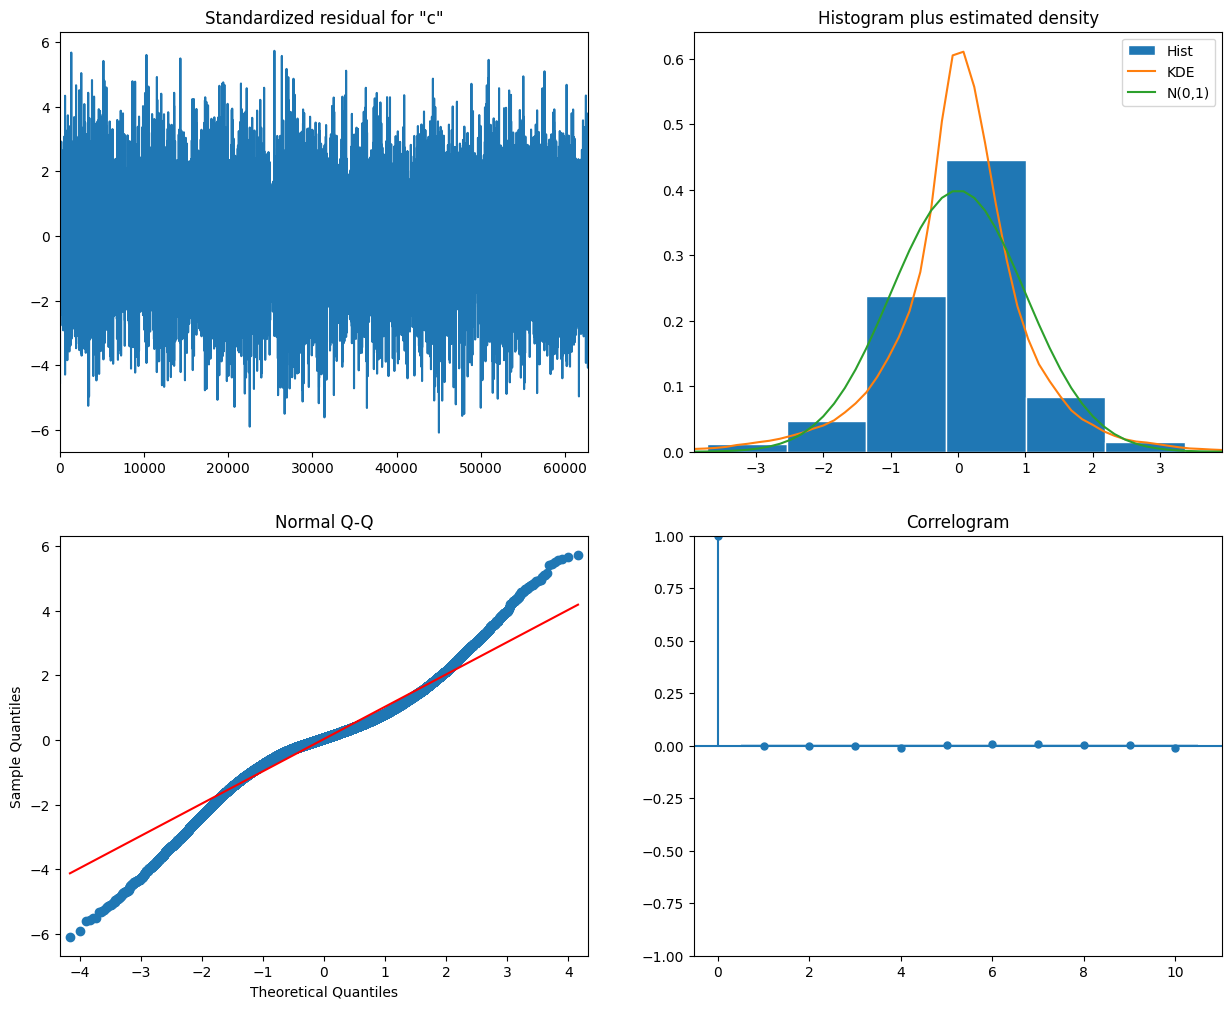

                                     SARIMAX Results                                      
Dep. Variable:                    co2_flux_filled   No. Observations:                62749
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -156819.649
Date:                            Mon, 03 Mar 2025   AIC                         313665.298
Time:                                    16:19:10   BIC                         313782.908
Sample:                                         0   HQIC                        313701.754
                                          - 62749                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SW_IN         -0.0076      0.000    -69.631      0.000      -0.008      -0.007
sin_1         -0.3288      0.041   

In [21]:
# Prognose für den Testzeitraum
forecast_steps = len(test_data)
forecast = final_model.get_forecast(steps=forecast_steps, exog=X_test if X_test is not None else None)
forecast_ci = forecast.conf_int()

# Visualisierung: Trainingsdaten, Testdaten und Prognose
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, y_train, label="Training")
plt.plot(test_data.index, y_test, label="Test")
plt.plot(test_data.index, forecast.predicted_mean, label="Forecast")
plt.fill_between(test_data.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.1)
plt.legend()
plt.show()

# Evaluation: Vorhersagegenauigkeit


mae = mean_absolute_error(y_test, forecast.predicted_mean)
rmse = np.sqrt(mean_squared_error(y_test, forecast.predicted_mean))
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# Diagnostics des finalen Modells
final_model.plot_diagnostics(figsize=(15, 12))
plt.show()
print(final_model.summary())



 Determining optimal differencing order...


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: F

Recommended differencing orders: d=0, D=0


<Figure size 1500x600 with 0 Axes>

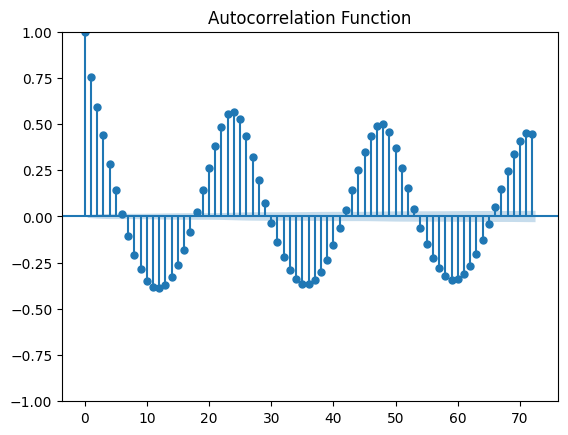

<Figure size 1500x600 with 0 Axes>

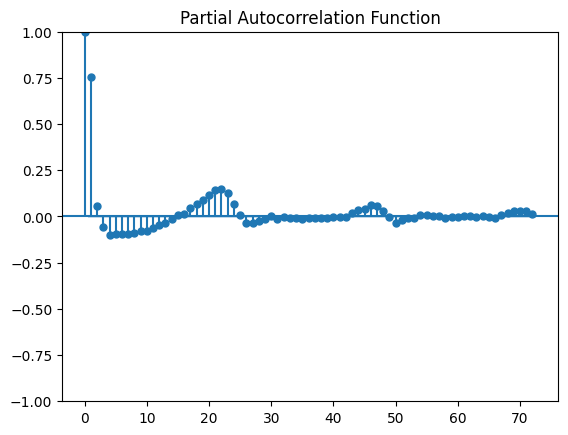

/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61289 instead
  warnings.warn(


Dask cluster initialized: <Client: 'tcp://127.0.0.1:61290' processes=8 threads=32, memory=29.80 GiB>

Starting parallel model search...


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 207.06 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



Best Model (AIC 314213.4):
SARIMAX(2, 0, 1)x(1, 0, 1, 24)


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


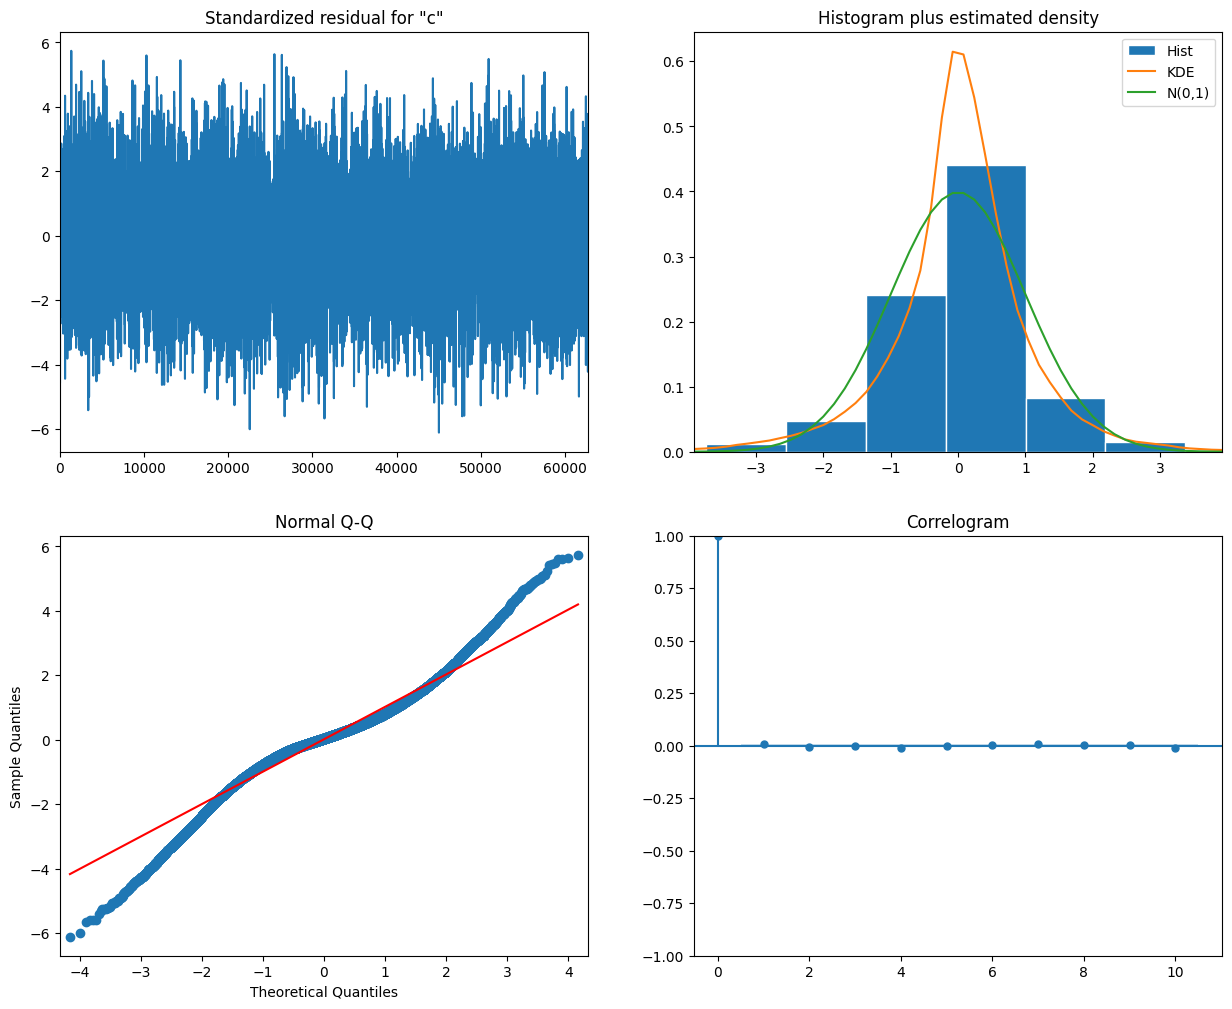

                                     SARIMAX Results                                      
Dep. Variable:                    co2_flux_filled   No. Observations:                62749
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -156774.982
Date:                            Mon, 03 Mar 2025   AIC                         313585.963
Time:                                    18:36:04   BIC                         313748.807
Sample:                                         0   HQIC                        313636.441
                                          - 62749                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SW_IN         -0.0080      0.000    -73.852      0.000      -0.008      -0.008
is_night       0.4518      0.065   

In [33]:
# 1. Memory-Optimized Data Preparation
def prepare_data(df, start_date, end_date):
    """Cleans and transforms the input data."""
    df = df.loc[start_date:end_date].resample('h').mean()
    
    # Memory optimizations
    numeric_cols = df.select_dtypes(np.float64).columns
    df[numeric_cols] = df[numeric_cols].astype(np.float32)
    
    # Reduce to required columns
    df = df[['co2_flux_filled', 'SW_IN']].copy()
    return df.dropna()

def create_fourier_terms(dates, freq=24, order=5):
    """
    Erstellt Fourier-Terme für Zeitreihen mit täglichem Zyklus.
    
    Args:
        dates: DatetimeIndex der Zeitreihe
        freq: Frequenz des Zyklus (24 für tägliche Daten mit stündlicher Auflösung)
        order: Anzahl der Fourier-Terme (höhere Ordnung = mehr Flexibilität)
    
    Returns:
        DataFrame mit Sinus- und Kosinus-Termen
    """
    fourier_terms = pd.DataFrame(index=dates)
    hours = pd.Series(dates.hour, index=dates)
    
    for i in range(1, order + 1):
        fourier_terms[f'sin_{i}'] = np.sin(2 * np.pi * i * hours / freq)
        fourier_terms[f'cos_{i}'] = np.cos(2 * np.pi * i * hours / freq)
    
    return fourier_terms

def add_is_night(df, start_hour=20, end_hour=6):
    """
    Erstellt eine Dummy-Variable is_night, die 1 ist, wenn die Stunde in [start_hour, 24) oder [0, end_hour),
    sonst 0. Standard: Nacht = 20 Uhr bis 6 Uhr.
    """
    df['is_night'] = ((df.index.hour >= start_hour) | (df.index.hour < end_hour)).astype(int)
    return df

# 2. Automated Differencing Determination
def determine_differencing(y):
    """Determines the optimal order of differencing using statistical tests."""
    print("\n Determining optimal differencing order...")
    
    # Non-seasonal differencing
    d = ndiffs(y, test='adf', max_d=2)
    
    # Seasonal differencing (24h)
    D = nsdiffs(y, m=24, test='ocsb', max_D=2)
    
    print(f"Recommended differencing orders: d={d}, D={D}")
    return d, D

# 3. Seasonality Analysis
def analyze_seasonality(y, lags=72):
    """Performs ACF/PACF analysis."""
    plt.figure(figsize=(15, 6))
    plot_acf(y, lags=lags, alpha=0.05, title="Autocorrelation Function")
    plt.show()
    
    plt.figure(figsize=(15, 6))
    plot_pacf(y, lags=lags, alpha=0.05, title="Partial Autocorrelation Function")
    plt.show()

# 4. Parallelization Setup
def initialize_cluster():
    """Starts a Dask cluster for parallel computations."""
    client = Client(n_workers=8, threads_per_worker=4, memory_limit='4GB')
    print("Dask cluster initialized:", client)
    return client

# 5. SARIMAX Model Fitting with Robust Error Handling
@dask.delayed
def fit_sarimax(y, X, order, seasonal_order):
    """Fits a SARIMAX model with robust error handling."""
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            model = SARIMAX(
                endog=y.astype(np.float32),
                exog=X.astype(np.float32) if X is not None else None,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=True,
                enforce_invertibility=True,
                initialization='approximate_diffuse'
            )
            
            result = model.fit(
                method='powell',
                maxiter=50,
                disp=False,
                low_memory=True
            )
            
            return {
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': result.aic,
                'bic': result.bic,
                'mae': mean_absolute_error(y, result.fittedvalues)
            }
            
    except Exception as e:
        print(f"Error with {order}{seasonal_order}: {str(e)[:80]}")
        return None
    finally:
        gc.collect()

# 6. Main Workflow with Extended Validations

# 6.1Load data
df = prepare_data(flux_df, '2015-01-01', '2023-12-31')

# # Split data into train and test sets
# train_end = '2022-12-31'
# train_data = df.loc[:train_end]
# test_data = df.loc[train_end:]

# y_train = train_data['co2_flux_filled']
# X_train = train_data[['SW_IN']]
# y_test = test_data['co2_flux_filled']
# X_test = test_data[['SW_IN']]

# 6.2 is_night hinzufügen
df = add_is_night(df, start_hour=20, end_hour=6)

# 6.3 Fourier-Terme erstellen und anhängen
fourier_terms = create_fourier_terms(df.index, freq=24, order=5)
df = pd.concat([df, fourier_terms], axis=1)



# Split data into train and test sets
train_end = '2022-12-31'
train_data = df.loc[:train_end]
test_data = df.loc[train_end:]


# 6.4 Trainings- und Testdaten vorbereiten X,Y sind exogene Variablen
y_train = train_data['co2_flux_filled']
X_train = train_data.drop(columns=['co2_flux_filled'])
y_test = test_data['co2_flux_filled']
X_test = test_data.drop(columns=['co2_flux_filled'])

# Determine differencing orders
d, D = determine_differencing(y_train)

# Seasonality analysis
analyze_seasonality(y_train)

# Parameter grid based on ACF/PACF
param_grid = {
    'p': [0, 1, 2],
    'q': [0, 1, 2],
    'P': [0, 1],
    'Q': [0, 1]
}

# Initialize cluster
client = initialize_cluster()

# Parallelized grid search
print("\nStarting parallel model search...")
tasks = []
for p in param_grid['p']:
    for q in param_grid['q']:
        for P in param_grid['P']:
            for Q in param_grid['Q']:
                tasks.append(
                    fit_sarimax(
                        y_train.values,
                        X_train.loc[y_train.index].values if X_train is not None else None,
                        (p, d, q),
                        (P, D, Q, 24)
                    )
                )

# Process results
results = dask.compute(*tasks)
valid_results = [r for r in results if r is not None]

if not valid_results:
    raise ValueError("No models successfully fitted")

results_df = pd.DataFrame(valid_results).sort_values('aic')

# Output best model
best_model = results_df.iloc[0]
print(f"\nBest Model (AIC {best_model.aic:.1f}):")
print(f"SARIMAX{best_model.order}x{best_model.seasonal_order}")

# Train final model
final_model = SARIMAX(
    y_train,
    exog=X_train.loc[y_train.index] if X_train is not None else None,
    order=best_model.order,
    seasonal_order=best_model.seasonal_order
).fit(disp=True)

# Diagnostics
final_model.plot_diagnostics(figsize=(15, 12))
plt.show()
print(final_model.summary())

# Close cluster
client.close()



/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


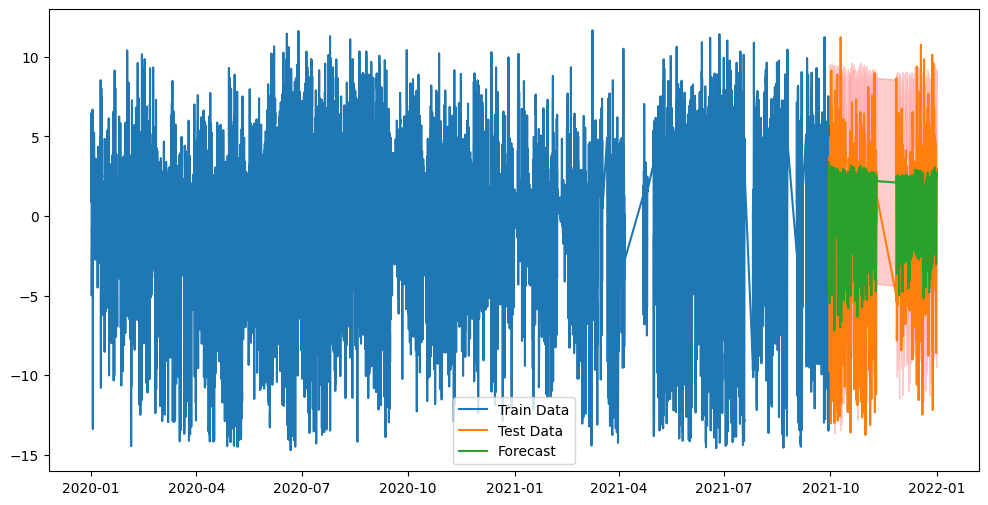

In [40]:
forecast_steps = len(X_test)
forecast = final_model.get_forecast(steps=forecast_steps, exog=X_test)

# Prognose und Konfidenzintervalle extrahieren
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Manuell den Index der Testdaten zuweisen:
forecast_mean.index = X_test.index
forecast_ci.index = X_test.index

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train Data')
plt.plot(y_test.index, y_test, label='Test Data')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)
plt.legend()
plt.show()

### Kleiner Trainings- und Testzeitraum

2025-03-04 17:48:15,069 - INFO - 
=== Starting Analysis ===
2025-03-04 17:48:15,070 - INFO - 
=== Data Preparation ===
2025-03-04 17:48:15,081 - INFO - 
Initial Data Information:
2025-03-04 17:48:15,082 - INFO - Shape: (11688, 1)
2025-03-04 17:48:15,082 - INFO - Columns: ['co2_flux_filled']
2025-03-04 17:48:15,083 - INFO - Missing Values:
co2_flux_filled    1195
dtype: int64
2025-03-04 17:48:15,084 - INFO - 
=== Adding Meteorological Data ===
2025-03-04 17:48:15,223 - INFO - 
=== Feature Engineering ===
2025-03-04 17:48:15,228 - INFO - 
After Feature Engineering Information:
2025-03-04 17:48:15,228 - INFO - Shape: (10493, 15)
2025-03-04 17:48:15,228 - INFO - Columns: ['co2_flux_filled', 'TA', 'SW_IN', 'is_night', 'TA_SWIN', 'TA_night', 'SW_IN_is_night', 'cos_daily_1', 'sin_daily_1', 'cos_daily_2', 'sin_daily_2', 'cos_yearly_1', 'sin_yearly_1', 'cos_yearly_2', 'sin_yearly_2']
2025-03-04 17:48:15,230 - INFO - Missing Values:
co2_flux_filled    0
TA                 0
SW_IN              0


Differenzierung: d=0, D=0


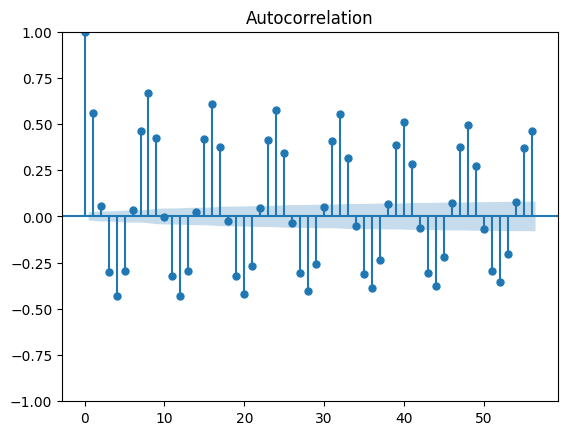

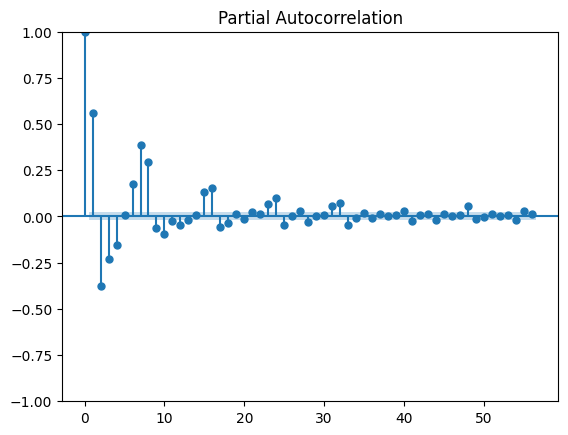

2025-03-04 17:48:15,926 - INFO - 
=== Model Training ===
2025-03-04 17:48:15,928 - INFO - SARIMAX Search Space:
2025-03-04 17:48:15,935 - INFO - Seasonality (m): 8
2025-03-04 17:48:15,936 - INFO - p range: 0-3, q range: 0-3
2025-03-04 17:48:15,937 - INFO - P range: 0-2, Q range: 0-2
2025-03-04 17:48:15,938 - INFO - d: 0, D: 0
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all


Starte Modelltraining...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=39124.534, Time=2.01 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=37534.919, Time=11.20 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=37715.093, Time=9.76 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[8]             : AIC=39459.119, Time=1.89 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=37813.927, Time=3.69 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[8] intercept   : AIC=37448.383, Time=21.08 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[8] intercept   : AIC=37340.816, Time=36.12 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[8] intercept   : AIC=37341.530, Time=14.49 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,2)[8] intercept   : AIC=37342.394, Time=45.05 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,2)[8] intercept   : AIC=37340.741, Time=34.45 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,2)[8] intercept   : AIC=37507.192, Time=26.08 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[8] intercept   : AIC=37585.745, Time=10.69 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,2)[8] intercept   : AIC=38319.009, Time=25.41 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,2)[8] intercept   : AIC=37342.265, Time=37.39 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[8] intercept   : AIC=37342.293, Time=36.03 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[8] intercept   : AIC=37456.854, Time=32.60 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[8] intercept   : AIC=37331.390, Time=69.40 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,2)[8] intercept   : AIC=37484.438, Time=65.02 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[8] intercept   : AIC=37332.372, Time=36.27 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,2)[8] intercept   : AIC=37334.182, Time=70.27 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[8] intercept   : AIC=37548.881, Time=34.18 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,1)[8] intercept   : AIC=37330.501, Time=69.05 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,0)[8] intercept   : AIC=37435.860, Time=67.04 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[8] intercept   : AIC=37509.269, Time=33.12 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,1)[8] intercept   : AIC=37342.368, Time=38.93 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[8] intercept   : AIC=37342.340, Time=37.26 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,0,1)[8] intercept   : AIC=37345.436, Time=71.36 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[8] intercept   : AIC=37345.354, Time=65.03 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,1)[8] intercept   : AIC=37343.352, Time=40.91 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,1)[8] intercept   : AIC=37343.472, Time=42.90 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,1)[8] intercept   : AIC=37347.301, Time=54.59 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-03-04 18:08:14,941 - INFO - 
=== Final Model ===
2025-03-04 18:08:14,943 - INFO - SARIMAX(2, 0, 1)x(2, 0, 1, 8)
2025-03-04 18:08:14,943 - INFO - Model Parameters:
2025-03-04 18:08:14,944 - INFO - intercept: -0.0089
2025-03-04 18:08:14,944 - INFO - SW_IN: -2.3342
2025-03-04 18:08:14,945 - INFO - is_night: 1.2181
2025-03-04 18:08:14,945 - INFO - TA_SWIN: 0.6235
2025-03-04 18:08:14,946 - INFO - TA_night: 1.3401
2025-03-04 18:08:14,946 - INFO - cos_daily_1: 2.0235
2025-03-04 18:08:14,947 - INFO - sin_daily_1: -0.4113
2025-03-04 18:08:14,947 - INFO - cos_daily_2: -0.5307
2025-03-04 18:08:14,947 - INFO - sin_daily_2: 0.4089
2025-03-04 18:08:14,948 - INFO - cos_yearly_1: 0.0863
2025-03-04 18:08:14,948 - INFO - sin_yearly_1: -0.1143
2025-03-04 18:08:14,948 - INFO - cos

 ARIMA(2,0,1)(2,0,1)[8]             : AIC=inf, Time=55.25 sec

Best model:  ARIMA(2,0,1)(2,0,1)[8] intercept
Total fit time: 1198.565 seconds

Optimales Modell: SARIMAX(2, 0, 1)x(2, 0, 1, 8)
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 8242
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 8)   Log Likelihood              -18645.250
Date:                           Tue, 04 Mar 2025   AIC                          37330.501
Time:                                   18:08:14   BIC                          37470.841
Sample:                                        0   HQIC                         37378.465
                                          - 8242                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------

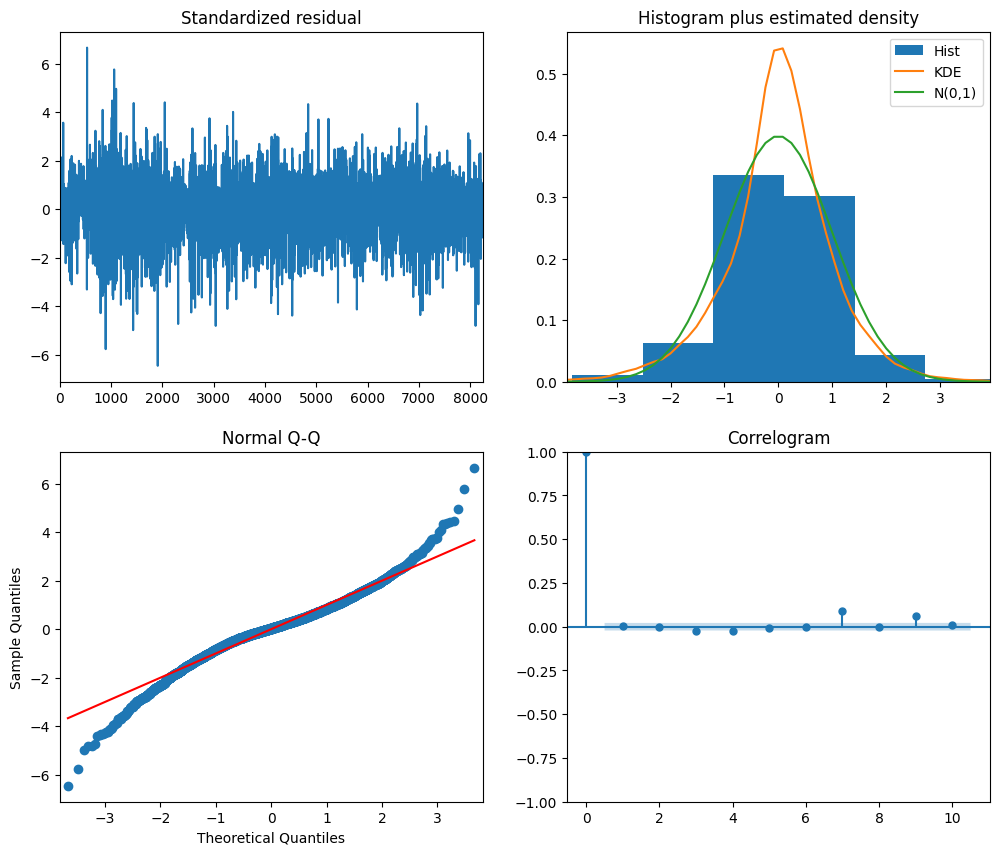

/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.w

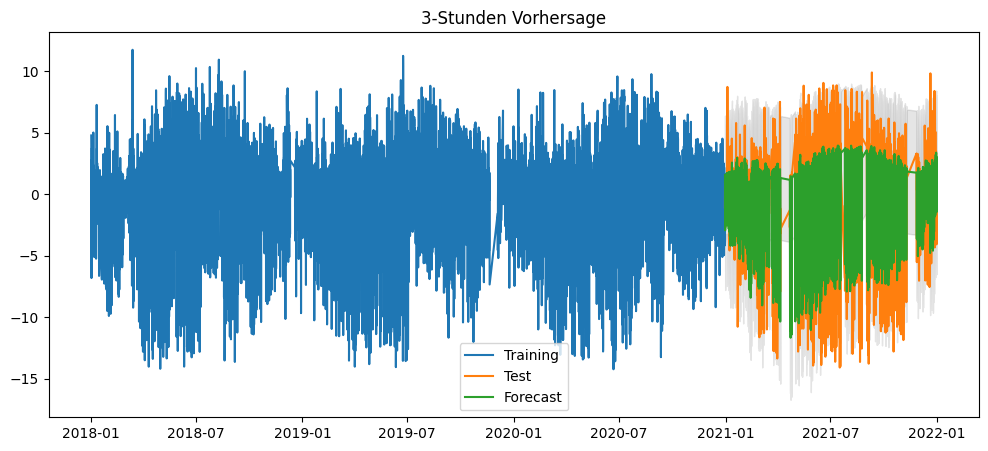

MAE: 2.0373
RMSE: 2.7681

Feature Wichtigkeit:
                   Feature        p-value
ar.L1          cos_daily_2  1.998264e-232
ma.L1         cos_yearly_1  1.005897e-137
ar.S.L8       sin_yearly_1  3.747174e-136
ma.S.L8       sin_yearly_2  1.623301e-102
ar.L2          sin_daily_2   6.910657e-63
cos_daily_2          SW_IN   8.052571e-25
sin_daily_2       is_night   2.869953e-15
sin_yearly_2   sin_daily_1   4.739650e-02
ar.S.L16      cos_yearly_2   1.560935e-01
sin_yearly_1      TA_night   3.960047e-01
cos_yearly_2   cos_daily_1   4.279138e-01
cos_yearly_1       TA_SWIN   5.482234e-01


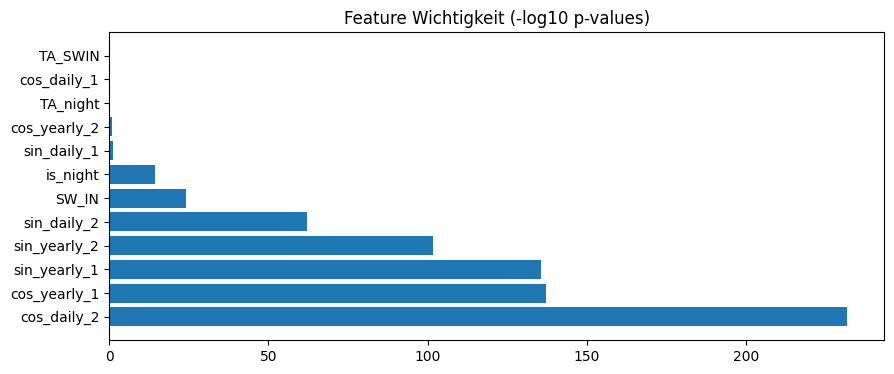

25519

In [17]:
# --- Logging Setup ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('sarimax_analysis.log'),
        logging.StreamHandler()
    ]
)

def log_dataframe_info(df, name):
    """Log basic dataframe information"""
    logging.info(f"\n{name} Information:")
    logging.info(f"Shape: {df.shape}")
    logging.info(f"Columns: {list(df.columns)}")
    logging.info(f"Missing Values:\n{df.isnull().sum()}")

def calculate_vif(X, threshold=5, whitelist=None):
    """Calculate VIF and remove problematic features"""
    
    if whitelist is None:
        whitelist = []
    
    X_with_const = X.copy()
    X_with_const['const'] = 1
    
    vif = pd.DataFrame()
    vif["Variable"] = X_with_const.columns
    vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                 for i in range(X_with_const.shape[1])]
    
    vif = vif[~vif['Variable'].isin(['const'] + whitelist)]
    high_vif = vif[vif.VIF > threshold]
    
    logging.info("\nVIF Analysis:")
    logging.info(f"VIF Threshold: {threshold}")
    logging.info(f"Initial Features:\n{vif.sort_values('VIF', ascending=False).to_string()}")
    logging.info(f"whitelist{whitelist}")
    
    removed = []
    while not high_vif.empty:
        candidates = high_vif[~high_vif['Variable'].isin(whitelist)]
        if candidates.empty:
            logging.info('Only whitelist items with high vif available - abort...')
            break
        worst_feature = high_vif.sort_values('VIF', ascending=False).iloc[0]['Variable']
        X = X.drop(columns=[worst_feature])
        removed.append(worst_feature)
        
        if X.empty:
            break
            
        X_with_const = X.copy()
        X_with_const['const'] = 1
        vif = pd.DataFrame({
            "Variable": X.columns,
            "VIF": [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(len(X.columns))]
        })
        high_vif = vif[vif.VIF > threshold]
    
    logging.info(f"\nRemoved features due to high VIF: {removed}")
    logging.info(f"Final Features:\n{vif.sort_values('VIF', ascending=False).to_string()}")
    
    return X, removed

# --- Data Preparation (3-Hour Intervals) ---
def prepare_data(df, start_date, end_date):
    """Cleans and transforms data with logging"""
    logging.info("\n=== Data Preparation ===")
    df = df.loc[start_date:end_date].resample('3h').mean()
    numeric_cols = df.select_dtypes(np.float64).columns
    df[numeric_cols] = df[numeric_cols].astype(np.float32)
    df = df[['co2_flux_filled']].copy()
    log_dataframe_info(df, "Initial Data")
    return df.dropna()

def create_fourier_terms(dates):
    """Fourier terms for 3-hour intervals and annual seasonality"""
    fourier_terms = pd.DataFrame(index=dates)
    
    # Daily seasonality (8 periods per day)
    hours = dates.hour
    fourier_terms['cos_daily_1'] = np.cos(2 * np.pi * (hours/3) / 8)
    fourier_terms['sin_daily_1'] = np.sin(2 * np.pi * (hours/3) / 8)
    fourier_terms['cos_daily_2'] = np.cos(4 * np.pi * (hours/3) / 8)
    fourier_terms['sin_daily_2'] = np.sin(4 * np.pi * (hours/3) / 8)

    # Annual seasonality
    dayofyear = dates.dayofyear
    fourier_terms['cos_yearly_1'] = np.cos(2 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_1'] = np.sin(2 * np.pi * dayofyear / 365.25)
    fourier_terms['cos_yearly_2'] = np.cos(4 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_2'] = np.sin(4 * np.pi * dayofyear / 365.25)

    return fourier_terms

def determine_day_night(df, sw_in_threshold=0):
    """Night Identifier"""
    df['is_night'] = (df['SW_IN'] < sw_in_threshold).astype(np.int8)
    return df

def interpolate_features(df, columns, method='linear', limit=8):
    """Interpolation for 3-hour data"""
    for col in columns:
        if col in df.columns:
            df[col] = df[col].interpolate(method=method, limit=limit, limit_direction='both')
    return df

def standardize_features(df, columns):
    """Standardization"""
    for col in columns:
        if col in df.columns:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

# --- Differencing ---
def determine_differencing(y):
    """Optimal Differencing"""
    d = ndiffs(y, test='adf', max_d=2)
    D = nsdiffs(y, m=8, test='ocsb', max_D=1)  # 8 periods per day
    print(f"Differencing: d={d}, D={D}")
    return d, D

def analyze_seasonality(y, lags=56):  # 7 days for 3-hour intervals
    """Seasonality Analysis"""
    plot_acf(y, lags=lags, alpha=0.05)
    plt.show()
    plot_pacf(y, lags=lags, alpha=0.05)
    plt.show()

# --- Main Workflow ---
# 1. Load Data
logging.info("\n=== Starting Analysis ===")
df = prepare_data(flux_df, '2018-01-01', '2021-12-31')

# 2. Add Meteorological Data
logging.info("\n=== Adding Meteorological Data ===")
meteo_data = meteorology[['TA_1_1_1', 'SW_IN_1_1_1']].resample('3h').mean()
meteo_data.columns = ['TA', 'SW_IN']
df = pd.merge(df, meteo_data, left_index=True, right_index=True, how='left')
df = interpolate_features(df, ['TA', 'SW_IN'])
df = standardize_features(df, ['TA', 'SW_IN'])
df = determine_day_night(df)

# 3. Feature Engineering
logging.info("\n=== Feature Engineering ===")
df['TA_SWIN'] = df['TA'] * df['SW_IN']
df['TA_night'] = df['TA'] * df['is_night']
df['SW_IN_is_night'] = df['SW_IN'] * (1 - df['is_night'])
df = pd.concat([df, create_fourier_terms(df.index)], axis=1)
log_dataframe_info(df, "After Feature Engineering")

# 4. Multicollinearity Check
logging.info("\n=== Multicollinearity Check ===")
X = df.drop(columns=['co2_flux_filled'])
X_filtered, removed = calculate_vif(X, threshold=5, whitelist= ['SW_IN'])
df = pd.concat([df[['co2_flux_filled']], X_filtered], axis=1)

# 5. Train/Test Split
logging.info("\n=== Train/Test Split ===")
train_end = '2020-12-31'
train_data = df.loc[:train_end]
test_data = df.loc[train_end:]

y_train = train_data['co2_flux_filled']
X_train = train_data.drop(columns=['co2_flux_filled'])
y_test = test_data['co2_flux_filled']
X_test = test_data.drop(columns=['co2_flux_filled'])

# 6. Differencing
logging.info("\n=== Differencing ===")
d, D = determine_differencing(y_train)
analyze_seasonality(y_train)

# 7. Auto-ARIMA with Expanded Search Space
logging.info("\n=== Model Training ===")
logging.info(f"SARIMAX Search Space:")
logging.info(f"Seasonality (m): 8")
logging.info(f"p range: 0-3, q range: 0-3")
logging.info(f"P range: 0-2, Q range: 0-2")
logging.info(f"d: {d}, D: {D}")
print("\nStarting model training...")
auto_model = pm.auto_arima(
    y=y_train,
    X=X_train,
    seasonal=True,
    m=8,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=d, D=D,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=4,
    information_criterion='aic',
    random_state=42,
    maxiter=100
)

# 8. Model Analysis
logging.info("\n=== Final Model ===")
logging.info(f"SARIMAX{auto_model.order}x{auto_model.seasonal_order}")
logging.info("Model Parameters:")
for param, value in auto_model.params().items():
    logging.info(f"{param}: {value:.4f}")
print(f"\nOptimal Model: SARIMAX{auto_model.order}x{auto_model.seasonal_order}")
print(auto_model.summary())
auto_model.plot_diagnostics(figsize=(12, 10))
plt.show()

# 9. Forecast
forecast, conf_int = auto_model.predict(
    n_periods=len(test_data),
    X=X_test,
    return_conf_int=True,
    alpha=0.05
)

# 10. Evaluation
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label='Training')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, forecast, label='Forecast')
plt.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title('3-Hour Forecast')
plt.show()

print(f"MAE: {mean_absolute_error(y_test, forecast):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, forecast)):.4f}")

# 11. Feature Importance
if hasattr(auto_model, 'arima_res_') and hasattr(auto_model.arima_res_, 'pvalues'):
    # Correct access method for pvalues (without parentheses!)
    exog_pvalues = auto_model.arima_res_.pvalues
    
    # Index calculation for exogenous variables
    arima_params_count = len(auto_model.order) + len(auto_model.seasonal_order)
    if len(exog_pvalues) > arima_params_count:
        # Extract only the p-values of the exogenous variables
        exog_pvalues = exog_pvalues[arima_params_count:]
        exog_names = X_train.columns
        
        # Ensure that the count matches
        n_features = min(len(exog_names), len(exog_pvalues))
        feature_importance = pd.DataFrame({
            'Feature': exog_names[:n_features],
            'p-value': exog_pvalues[:n_features]
        }).sort_values('p-value')

        print("\nFeature Importance:")
        print(feature_importance)
        
        plt.figure(figsize=(10, 4))
        plt.barh(feature_importance['Feature'], -np.log10(feature_importance['p-value']))
        plt.title('Feature Importance (-log10 p-values)')
        plt.show()

# 12. Cleanup & Save
del df, train_data, test_data
gc.collect()